In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - orbital_parameters.ipynb
# AUTHOR - James Lane
# PROJECT - OHStars
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Generate orbital parameters for the 6 outer halo stars. Sample 5D gaia kinematics with covariances and
determine orbital parameters and uncertainties using a MC approach.
'''

__author__ = "James Lane"

In [2]:
### Imports

## Basic
import numpy as np
import sys, os, pdb, warnings
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import cm

## Astropy
# from astropy.io import fits
# from astropy.coordinates import SkyCoord
from astropy import table
from astropy import units as apu
from astropy.utils.exceptions import AstropyWarning
# from astropy import wcs

## galpy
from galpy import orbit
from galpy import potential
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv
from galpy.util import bovy_plot as gpplot

# Project-specific
sys.path.append('../../src')
import ohstars.analysis

In [3]:
### Change Jupyter settings

from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Markdown, display

# Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

# Meta
## Future Work

## Information
- Gaia co-variance information: https://www.aanda.org/articles/aa/pdf/2012/07/aa18807-12.pdf

# Preparation
## Keywords

In [40]:
# Number of samples
n_samples = 100

# Perform the analysis on all stars? True for skip
exclude_stars = [False,True,True,True,True,True]

# Integration keywords
t_orbit = [2,10,1,40,3,2] # Gyr

# Declare the potential
pot = potential.MWPotential2014


## Read Data

In [5]:
# Filename
filename = '../../data/gaia/allstars.vot'

# Read the file
with warnings.catch_warnings():
    warnings.simplefilter('ignore', AstropyWarning)
    tab = table.Table.read(filename)
    
n_stars = len(tab) # 6
star_names = tab['col1'].data.astype(str)

## Prepare RV Data

In [6]:
# RV is uncorrelated with gaia so sample individually. From some Table I have (ref? In paper?)
vrad = np.array([-314.41, -136.80, -361.75, -372.09, -321.48, -214.37 ])
vrad_err = np.array([0.26,0.14,0.67,0.32,0.28,0.26])

# Integrate
Loop over each star and determine orbital parameters

A Jupyter Widget

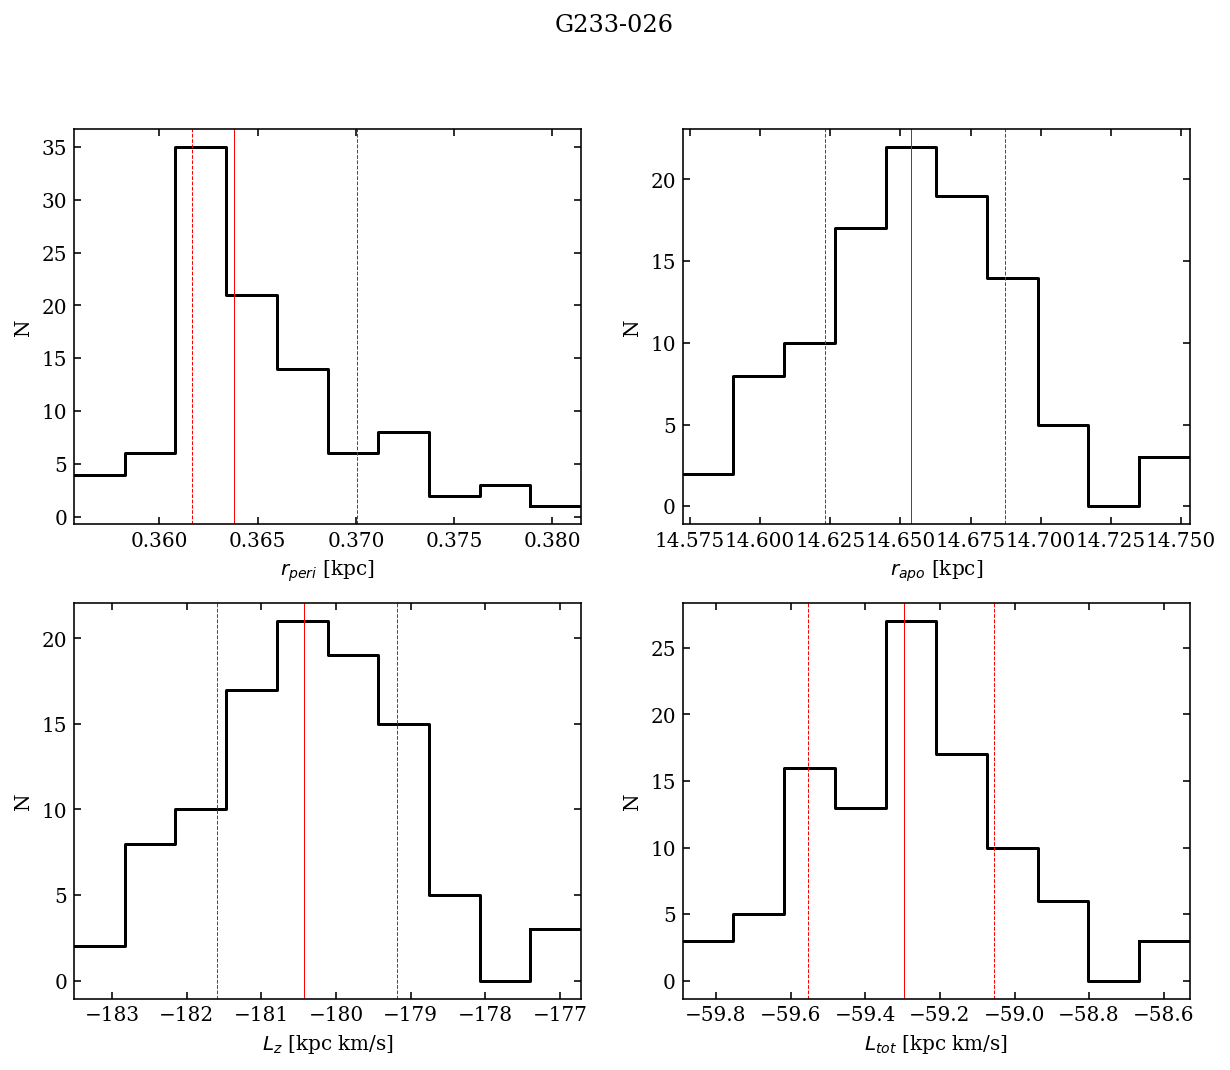

In [42]:
# Make the figure
fig = plt.figure( figsize=(10,8) )
axs = fig.subplots( nrows=2, ncols=2 )

for i in range(n_stars):
    
    # Evaluate?
    if exclude_stars[i]:
        continue
    ##fi
    
    # Sample the data
    samples, _ = ohstars.analysis.sample_kinematics( tab[i], n_samples=n_samples )
    rv_samples = np.random.normal( vrad[i], vrad_err[i], size=n_samples )
    
    # Timing:
    n_snaps = 1000 * t_orbit[i] # 1/Myr
    times = np.linspace(0,t_orbit[i],n_snaps) * apu.Gyr
    
    # Arrays to hold output parameters
    peri = np.zeros(n_samples)
    apo = np.zeros(n_samples)
    Lz = np.zeros(n_samples)
    Ltot = np.zeros(n_samples)
    
    # Loop over the trials
    for j in tqdm_nb( range(n_samples) ):
        
        # Unpack the sample:
        ra, dec, par, pmra, pmdec = samples[j]
        rv = rv_samples[i]
        dist = 1/par # In kpc
        
        # Now declare the orbit
        o = orbit.Orbit( vxvv=[ra, dec, dist, pmra, pmdec, rv], radec=True )
        
        # Integrate
        o.integrate(times, pot)
        
        # Output
        peri[j] = o.rperi().value # Kpc
        apo[j] = o.rap().value # Kpc
        Lz[j] = np.average( o.vT(times) * o.R(times) ).value # Kpc Km/s
        Ltot[j] = np.average( o.L(times) ).value # Kpc Km/s
        
    # Plot
    
    peri_n, peri_bins = np.histogram(peri)
    # axs[0,0].hist(peri)
    axs[0,0].step(peri_bins[:-1], peri_n, where='post', color='Black')
    axs[0,0].plot([peri_bins[-2],peri_bins[-1]], [peri_n[-1],peri_n[-1]], color='Black')
    axs[0,0].axvline( np.median(peri), linestyle='solid', color='Red', linewidth=0.5 )
    axs[0,0].axvline( np.sort(peri)[ int(0.84*n_samples) ], linestyle='dashed', color='Red', linewidth=0.5 )
    axs[0,0].axvline( np.sort(peri)[ int(0.16*n_samples) ], linestyle='dashed', color='Red', linewidth=0.5 )
    
    apo_n, apo_bins = np.histogram(apo)
    # axs[0,1].hist(apo)
    axs[0,1].step(apo_bins[:-1], apo_n, where='post', color='Black')
    axs[0,1].plot([apo_bins[-2],apo_bins[-1]], [apo_n[-1],apo_n[-1]], color='Black')
    axs[0,1].axvline( np.median(apo), linestyle='solid', color='Red', linewidth=0.5 )
    axs[0,1].axvline( np.sort(apo)[ int(0.84*n_samples) ], linestyle='dashed', color='Red', linewidth=0.5 )
    axs[0,1].axvline( np.sort(apo)[ int(0.16*n_samples) ], linestyle='dashed', color='Red', linewidth=0.5 )
    
    Lz_n, Lz_bins = np.histogram(Lz)
    # axs[1,0].hist(Lz)
    axs[1,0].step(Lz_bins[:-1], Lz_n, where='post', color='Black')
    axs[1,0].plot([Lz_bins[-2],Lz_bins[-1]], [Lz_n[-1],Lz_n[-1]], color='Black')
    axs[1,0].axvline( np.median(Lz), linestyle='solid', color='Red', linewidth=0.5 )
    axs[1,0].axvline( np.sort(Lz)[ int(0.84*n_samples) ], linestyle='dashed', color='Red', linewidth=0.5 )
    axs[1,0].axvline( np.sort(Lz)[ int(0.16*n_samples) ], linestyle='dashed', color='Red', linewidth=0.5 )
    
    Ltot_n, Ltot_bins = np.histogram(Ltot)
    # axs[1,1].hist(Ltot)
    axs[1,1].step(Ltot_bins[:-1], Ltot_n, where='post', color='Black')
    axs[1,1].plot([Ltot_bins[-2],Ltot_bins[-1]], [Ltot_n[-1],Ltot_n[-1]], color='Black')
    axs[1,1].axvline( np.median(Ltot), linestyle='solid', color='Red', linewidth=0.5 )
    axs[1,1].axvline( np.sort(Ltot)[ int(0.84*n_samples) ], linestyle='dashed', color='Red', linewidth=0.5 )
    axs[1,1].axvline( np.sort(Ltot)[ int(0.16*n_samples) ], linestyle='dashed', color='Red', linewidth=0.5 )
    
    # Decorate
    axs[0,0].set_xlim( np.min(peri), np.max(peri) )
    axs[0,1].set_xlim( np.min(apo), np.max(apo) )
    axs[1,0].set_xlim( np.min(Lz), np.max(Lz) )
    axs[1,1].set_xlim( np.min(Ltot), np.max(Ltot) )
    
    axs[0,0].set_xlabel(r'$r_{peri}$ [kpc]')
    axs[0,1].set_xlabel(r'$r_{apo}$ [kpc]')
    axs[1,0].set_xlabel(r'$L_{z}$ [kpc km/s]')
    axs[1,1].set_xlabel(r'$L_{tot}$ [kpc km/s]')
    
    axs[0,0].set_ylabel('N')
    axs[0,1].set_ylabel('N')
    axs[1,0].set_ylabel('N')
    axs[1,1].set_ylabel('N')
    
    fig.suptitle(star_names[i])
    
plt.show()
plt.close('all')

# No output
pass;